# Exploratory Analysis on Spark Streaming Dataset 

This is going to be really fun, since we are gonna consider raw data and explore whether it makes sense for us to use it for our purpose.

What's our purpose?
- We wanted to do a text classification, to determine whether the collected data make sense to get mannully tagged.
- We must ensure taht we have right kind of data with us before we spend time in tagging them for supervised learning

## Must Read Topics
- KL Divergence
    - https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import imageio
plt.style.use('ggplot')
import json
import re
import nltk
# nltk.download('punkt')
import spacy
import textacy
import numpy as np
import sys
from tqdm import tqdm, tqdm_notebook
# tqdm.pandas()
sys.path.append("../../../src/")


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.pipeline import FeatureUnion, Pipeline 

In [3]:
from ssp.ml.estimator import TextFeatureEngineering
from ssp.ml.transformer import TextPreProcessor
from ssp.ml.transformer import SSPTextLabeler
from ssp.viz.word_cloud import plot_word_cloud

In [4]:
TEXT_COL="text"
TEXT_PROCESSED_COL = "text_processed"
TEXT_FEATURE_ENG_COL = "text_features"
ssp_LF_dataset = pd.read_parquet("original/ssp_LF_dataset.parquet", engine="fastparquet")

In [5]:
text_preprocessor_transformer = TextPreProcessor(input_col=TEXT_COL, output_col=TEXT_PROCESSED_COL)
text_feature_eng_transformer = TextFeatureEngineering(input_col=TEXT_PROCESSED_COL, 
                                                      output_col=TEXT_FEATURE_ENG_COL,
                                                      max_features=4096, 
                                                      ngram_range=(1, 2))
ssp_labeler = SSPTextLabeler(input_col=TEXT_PROCESSED_COL, config_file_path="../../../config.ini")

Reading _config from : ../../../config.ini


In [6]:
# plot_word_cloud(df=ssp_LF_dataset, text_col=TEXT_COL)

## Data Preprocessing

In [7]:
ssp_LF_dataset = text_preprocessor_transformer.transform(ssp_LF_dataset)
ssp_LF_dataset = ssp_labeler.transform(ssp_LF_dataset)
ssp_LF_dataset


1    555
0    445
Name: label, dtype: int64


,id,text,text_processed,label
1500,0,⁦@rahimzmohamed⁩ bored already from working at...,bored already working home have little look 20...,1
1501,1,Top AI Resources - Directory for Remote Learni...,top ai resources directory remote learning l...,1
1502,2,@Marshmellowjelo Hi guys.. this one is soo coo...,marshmellowjelo hi guys one soo cool how plan ...,0
1503,3,@CiccioSalvo33 @ISoPonline @EMA_News And knowi...,cicciosalvo33 isoponline emanews and knowing p...,0
1504,4,"Before you reply, perhaps take a minute to do ...",before reply perhaps take minute maths househo...,0
...,...,...,...,...
2495,995,This is a great article by @joejsmiddleton on ...,this great article joejsmiddleton 10downingstr...,1
2496,996,god my face hurts from laughing at the half li...,god face hurts laughing half life vr ai selfaw...,1
2497,997,ACR outlines 10 priorities to steer federal ov...,acr outlines 10 priorities steer federal overs...,1
2498,998,.@AHSD25Patton community check this out! @Patt...,ahsd25patton community check out pattonart con...,0


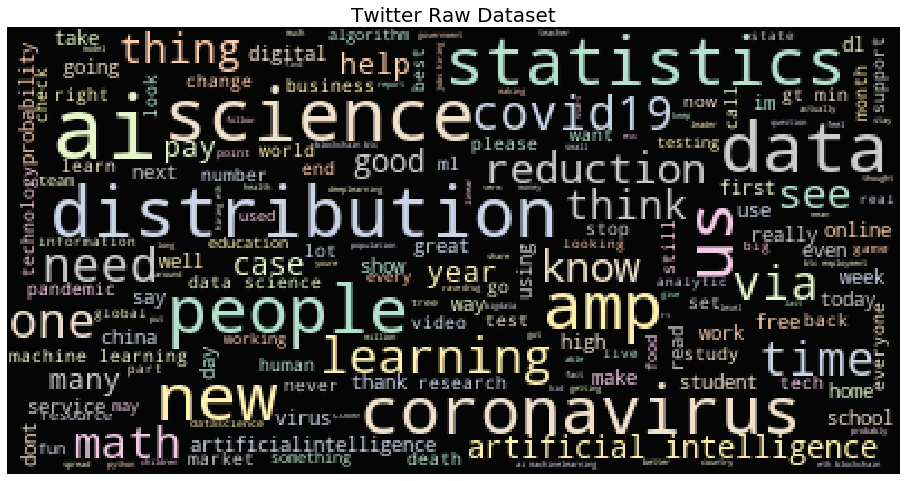

In [9]:
plot_word_cloud(df=ssp_LF_dataset, text_col=TEXT_PROCESSED_COL)

#https://medium.com/reputation-com-datascience-blog/keywords-extraction-with-ngram-and-modified-skip-gram-based-on-spacy-14e5625fce23

## Feature Engineering

In [10]:
text_feature_eng_transformer = text_feature_eng_transformer.fit(ssp_LF_dataset)
text_features = text_feature_eng_transformer.transform(ssp_LF_dataset)

In [11]:
text_features.shape

(1000, 4096)

### Dimensionality Reduction

Now we have extracted enough features for our training, but can we work with such high dimensional data? 
Dependending on the number of records the answer is yes/no. Considering the answer is no, as our systems can't hold huge arrays, lets reduce the features?

But wait? how do we know which one should keep and which should throw away?

Lets give that jobs to dimensionality reductions models/algorithms which can do it in more statistical way.


In [12]:
tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(text_features)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.127s...
[t-SNE] Computed neighbors for 1000 samples in 6.846s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.965301
[t-SNE] KL divergence after 250 iterations with early exaggeration: 181.879852
[t-SNE] KL divergence after 1000 iterations: 3.990238


(1000, 2)

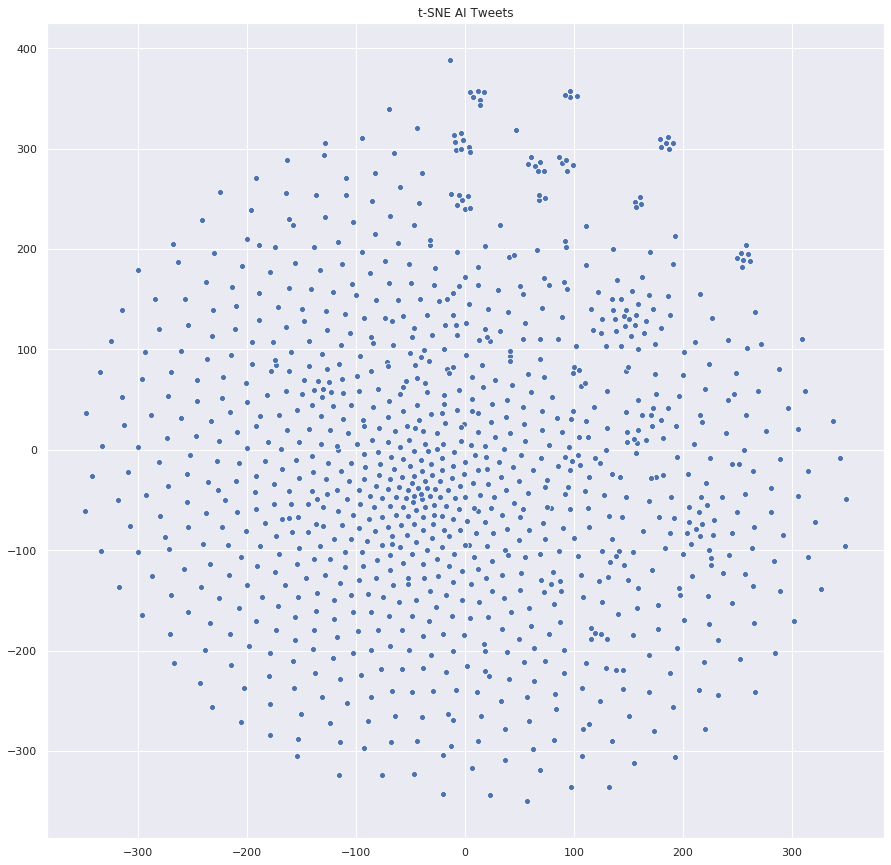

In [24]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE AI Tweets")
#plt.savefig("plots/t-sne_covid19.png")
plt.show()

In [27]:
X_embedded.shape

(1000, 2)

In [7]:
# LDA

## Clustering

In [8]:
# KMeans

k = 2
kmeans = KMeans(n_clusters=k, n_jobs=4, verbose=10)
y_pred = kmeans.fit_predict(X_embedded)

NameError: name 'X_embedded' is not defined

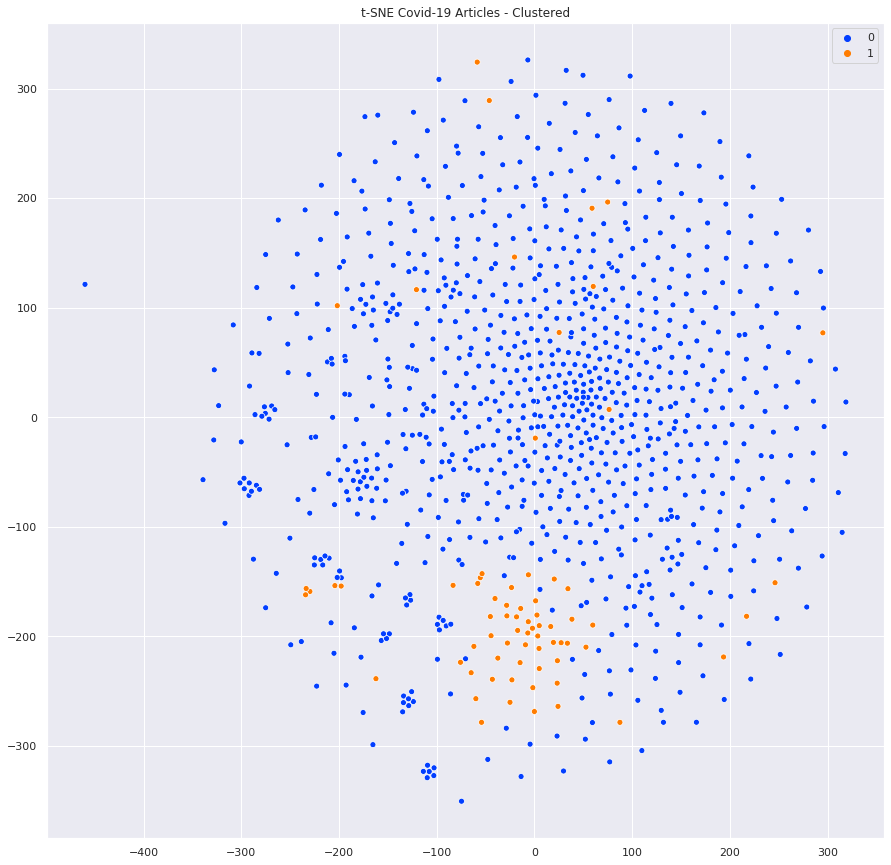

In [31]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
#plt.savefig("plots/t-sne_covid19_label.png")
plt.show()

In [9]:
# LDA -> KMeans

In [ ]:
# Clustering Validation Metrics
# siloutte score
# perplexicity 

**References**
- https://www.kaggle.com/maksimeren/covid-19-literature-clustering